# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

## Загрузка и подготовка данных

In [1]:
import pandas as pd
import numpy as np
import math

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_squared_error

from sklearn.linear_model import LinearRegression

import catboost as cb

In [2]:
data = pd.read_csv('/Users/mune_amour/Downloads/geo_data_0.csv')
data_1 = pd.read_csv('/Users/mune_amour/Downloads/geo_data_1.csv')
data_2 = pd.read_csv('/Users/mune_amour/Downloads/geo_data_2.csv')

In [3]:
COSTS = 10_000_000_000  # 10 млрд рублей
BARREL_PRICE = 450_000  # цена одного барреля сырья (тыс. рублей)
UNIT_PROFIT = 450  # доход с каждой единицы продукта (тыс. рублей)

N_BEST = 200  # количество скважин, которые будут выбраны для разработки
MIN_LOSS_PROB = 0.025  # максимально допустимая вероятность убытков

DATA_LIST = {'dataset_1': data, 'dataset_2': data_1, 'dataset_3': data_2}

In [4]:
data_1['f2'] = np.log((data_1['f2'])**2)

Добавим шума в данные, поскольку переменная f2 имеет высокую степень корреляции с целевым признаком

Для dataset_1 матрица корреляции выглядит следующим образом: 


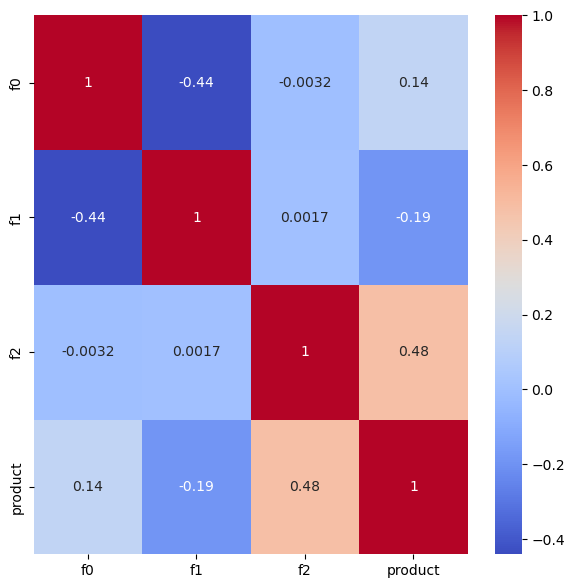

Для dataset_2 матрица корреляции выглядит следующим образом: 


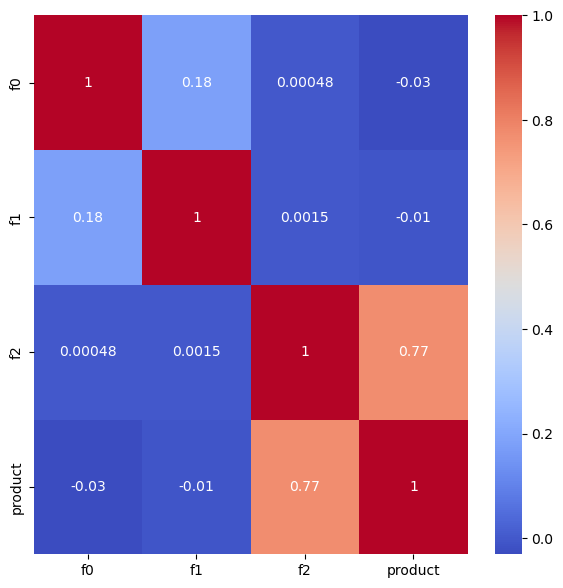

Для dataset_3 матрица корреляции выглядит следующим образом: 


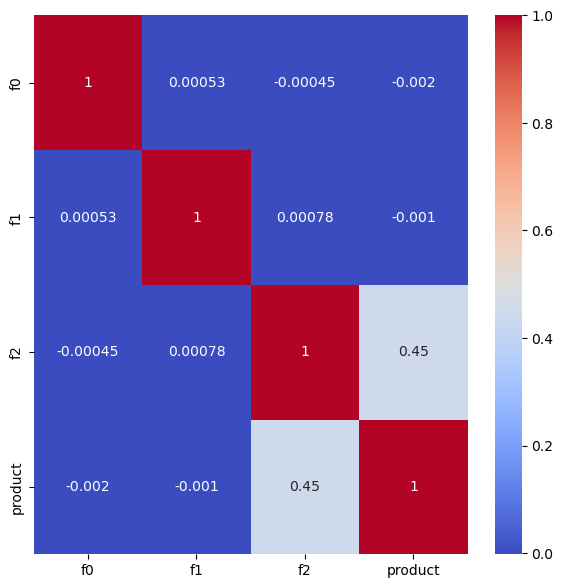

In [5]:
for key, value in DATA_LIST.items():
    
    print(f'Для {key} матрица корреляции выглядит следующим образом: ')
    # Построение матрицы корреляции
    corr_matrix = value.corr()
    plt.figure(figsize=(7, 7))
    phik_map = sns.heatmap(corr_matrix, cmap='coolwarm', annot=True)
    plt.show() 

**ВЫВОД:**

Данные датасета data_1 отличаются от остальных, за счет высокой корреляции между столбцом f2 и product (0.97). Данная тенденция плохо влияет на обучаемость (переобучаемость) модели, поскольку линейная регрессия будет слишком сильно опираться на эту переменную.

Остальные данные не имеют такой проблемы

## Обучение и проверка модели

In [6]:
def train_lr(data, verbose=True):
    
    features = data.drop(['product', 'id'], axis = 1)
    target = data['product']

    # разделение на тренировочную и валидационную 
    features_train, features_valid, target_train, target_valid = train_test_split(features, target, 
                                                                                  test_size=0.25, 
                                                                                  random_state=42)
    # Создание модели логистической регрессии
    model = LinearRegression()
    # Обучение модели на тренировочной выборке
    model.fit(features_train, target_train)
    
    # Получение предсказаний для валидационной выборки
    predicted_valid = model.predict(features_valid)
    predicted_valid = pd.Series(predicted_valid)
    
    rmse = mean_squared_error(target_valid, predicted_valid)**.5
    prod_mean = predicted_valid.mean()
    if verbose == True:
        print(f'Реальный средний объем запасов: {target.mean()}')
        print('Средний объем предсказанных запасов:', prod_mean)
        print('Среднеквадратичная ошибка:', rmse)
        if prod_mean >= min_product_per_weil:
            print(f'Регион подходит по минимальным требованиям к разработке')
        else:
            print(f'Регион не подходит по минимальным требованиям к разработке')
        print('...')
    return target_valid, predicted_valid, prod_mean

min_profit_per_weil - минимальная прибыль с одной скважины для безубыточной разработки, руб.

min_product_per_weil - минимальный объем запасов с одной скважины для безубыточной разработки, тыс. баррелей
                                                                                        

In [7]:
min_profit_per_weil = COSTS / N_BEST 
min_product_per_weil = (min_profit_per_weil / UNIT_PROFIT)/1000 

for key, value in DATA_LIST.items():
    print(f'Для датасета {key}:') 
    train_lr(value)

Для датасета dataset_1:
Реальный средний объем запасов: 92.49999999999974
Средний объем предсказанных запасов: 92.3987999065781
Среднеквадратичная ошибка: 37.75660035026169
Регион не подходит по минимальным требованиям к разработке
...
Для датасета dataset_2:
Реальный средний объем запасов: 68.82500000002561
Средний объем предсказанных запасов: 68.72763217162688
Среднеквадратичная ошибка: 29.10464873179048
Регион не подходит по минимальным требованиям к разработке
...
Для датасета dataset_3:
Реальный средний объем запасов: 95.00000000000041
Средний объем предсказанных запасов: 94.77102387765994
Среднеквадратичная ошибка: 40.14587231134218
Регион не подходит по минимальным требованиям к разработке
...


In [8]:
target_valid_1, predicted_valid_1, prod_mean_1 = train_lr(data, verbose = False)
target_valid_2, predicted_valid_2, prod_mean_2 = train_lr(data_1, verbose = False)
target_valid_3, predicted_valid_3, prod_mean_3 = train_lr(data_2, verbose = False)

Полученный объем сырья для безубыточной разработки новой скважины в каждом регионе оказался значительно выше, чем средний запас предсказанного сырья. Это означает, что для разработки каждой скважины в любом из регионов необходимо добывать существенно больше, чем средний запас предсказанных запасов.

Этот вывод говорит о том, что нужно разрабатывать скважины, которые имеют предсказанные запасы выше среднего. Также, это может быть связано с тем, что модель не совсем точна, и предсказанные значения запасов сырья могут существенно отличаться от реальных значений. Таким образом, необходимо учитывать этот факт при принятии решений.

Кроме того, важно иметь в виду, что необходимо учитывать и другие факторы при выборе региона для разработки, такие как доступность инфраструктуры, логистические затраты и т.д.

In [9]:
def revenue_predict(target, predictions):
#     target = target.reset_index(drop=True)
#     predictions = pd.Series(predictions, index=target.index)
    # Сортируем предсказания по убыванию
    predictions_sorted = predictions.sort_values(ascending=False)
    
    # Выбираем скважины с максимальными значениями предсказаний
    selected = target[predictions_sorted.index][:200]
    # Суммируем целевое значение объёма сырья, соответствующее выбранным скважинам
    total_target = selected.sum()
    # Рассчитываем прибыль для полученного объёма сырья
    revenue = total_target * BARREL_PRICE - COSTS
    return revenue

In [10]:
def bootstrap(predicted, target, count = 500):
    state = np.random.RandomState(12345)
    revenue = []
    target = target.reset_index(drop=True)
    predicted = pd.Series(predicted, index=target.index)
    for i in range(1000):        
        target_sample = target.sample(n = count, replace=True, random_state=state)
        predict_sample = predicted[target_sample.index]
        revenue_subsample = revenue_predict(target_sample, predict_sample)
        revenue.append(revenue_subsample)
    return pd.Series(revenue)

## Расчёт прибыли и рисков 

In [11]:
# Регион 1
revenue_1 = bootstrap(predicted_valid_1, target_valid_1)
mean_revenue_1 = revenue_1.mean()
confidence_interval_1 = np.percentile(revenue_1, [2.5, 97.5])
loss_prob1 = (revenue_1 < 0).mean() 

print('Регион 1:')
print(f'Средняя прибыль: {mean_revenue_1:.2f} рублей')
print(f'95%-ый доверительный интервал: [{confidence_interval_1[0]:.2f}, {confidence_interval_1[1]:.2f}]')
print(f'Вероятность убытков: {loss_prob1:.2%}')

# Регион 2
revenue_2 = bootstrap(predicted_valid_2, target_valid_2)
mean_revenue_2 = revenue_2.mean()
confidence_interval_2 = np.percentile(revenue_2, [2.5, 97.5])
loss_prob_2 = (revenue_2 < 0).mean()

print('\nРегион 2:')
print(f'Средняя прибыль: {mean_revenue_2:.2f} рублей')
print(f'95%-ый доверительный интервал: [{confidence_interval_2[0]:.2f}, {confidence_interval_2[1]:.2f}]')
print(f'Вероятность убытков: {loss_prob_2:.2%}')

# Регион 3
revenue_3 = bootstrap(predicted_valid_3, target_valid_3)
mean_revenue_3 = revenue_3.mean()
confidence_interval_3 = np.percentile(revenue_3, [2.5, 97.5])
loss_prob_3 = (revenue_3 < 0).mean()

print('\nРегион 3:')
print(f'Средняя прибыль: {mean_revenue_3:.2f} рублей')
print(f'95%-ый доверительный интервал: [{confidence_interval_3[0]:.2f}, {confidence_interval_3[1]:.2f}]')
print(f'Вероятность убытков: {loss_prob_3:.2%}')


Регион 1:
Средняя прибыль: 435933772.14 рублей
95%-ый доверительный интервал: [-116231612.78, 966504180.71]
Вероятность убытков: 6.10%

Регион 2:
Средняя прибыль: 480752932.11 рублей
95%-ый доверительный интервал: [53721346.02, 863841517.88]
Вероятность убытков: 1.10%

Регион 3:
Средняя прибыль: 403687927.86 рублей
95%-ый доверительный интервал: [-153116984.76, 952887416.71]
Вероятность убытков: 7.10%


**Вывод: **
    
Исходя из данных, полученных в ходе отработки кода наиболее логичным вариантом является использование 2 региона, как наиболее предпочтительного для разработки. На втором месте стоит регион под номером 1 и последнее место имеет 3 регион